## Determining Power Generation Investment Efficiency, by world region

The IEA (International Energy Agency) recently released their 2024 World Energy Outlook: https://www.iea.org/reports/world-energy-outlook-2024, showing projected forecasts for metrics such as electricity generation and investment. The goal of this project is to determine the approximate return on investment in power generation for different world regions, as expressed by the ratio terawatt hours (TWh) per billion dollars invested.

The project structure is outlined as follows:

1. Obtain data
2. Exploratory data analysis
3. Interpolate data for missing years
4. Perform ratio operations
5. Interpret results

## Obtain data

We are using data from the International Energy Agency (IEA):

1. World Energy Outlook 2024: https://www.iea.org/data-and-statistics/data-product/world-energy-outlook-2024-free-dataset
2. World Energy Investment 2024: https://www.iea.org/data-and-statistics/data-product/world-energy-investment-2024-datafile

From the first dataset we will examine table A.16: "Electricity Generation for Key Regions". This includes projected energy generation for years 2030, 2035, and 2050, based on the IEA's "stated policies scenario" (https://www.iea.org/reports/global-energy-and-climate-model/stated-policies-scenario-steps), a more conservative estimate of the future, which does not take for granted that governments will reach all announced goals relating to renewables transitions.

From the second, we will examine the tables in sheets 6-12 which show investment numbers for the following regions: North America, Central and South America, Europe, Africa, Middle East, Eurasia, and Asia Pacific. For this project, I will also be breaking down the Asia-Pacific Region into categories "China" and "Other Asia Pacific", due to China's scale.

## Exploratory Data Analysis

We will:

1. View and plot power generation data by region
2. View and plot investment in power generation by region
3. Visualize the energy mix for each region (oil and gas, nuclear, renewables, etc)
4. Explore trends in the raw data

Electricity Generation (TWh) for Key Regions, Stated Policies Scenario

                          2010  2022  2023  2030  2035  2050
            North America 5230  5468  5390  5979  6704  8955
Central and South America 1129  1372  1419  1691  1951  2921
                   Europe 4119  3980  3885  4719  5508  6893
                   Africa  687   901   913  1203  1460  2459
              Middle East  829  1342  1370  1773  2087  3236
                  Eurasia 1251  1457  1477  1593  1688  1949
             Asia Pacific 8265 14625 15409 20531 23368 31940
                    China 4236  8947  9566 12967 14495 18956
       Other Asia Pacific 4029  5678  5843  7564  8873 12984


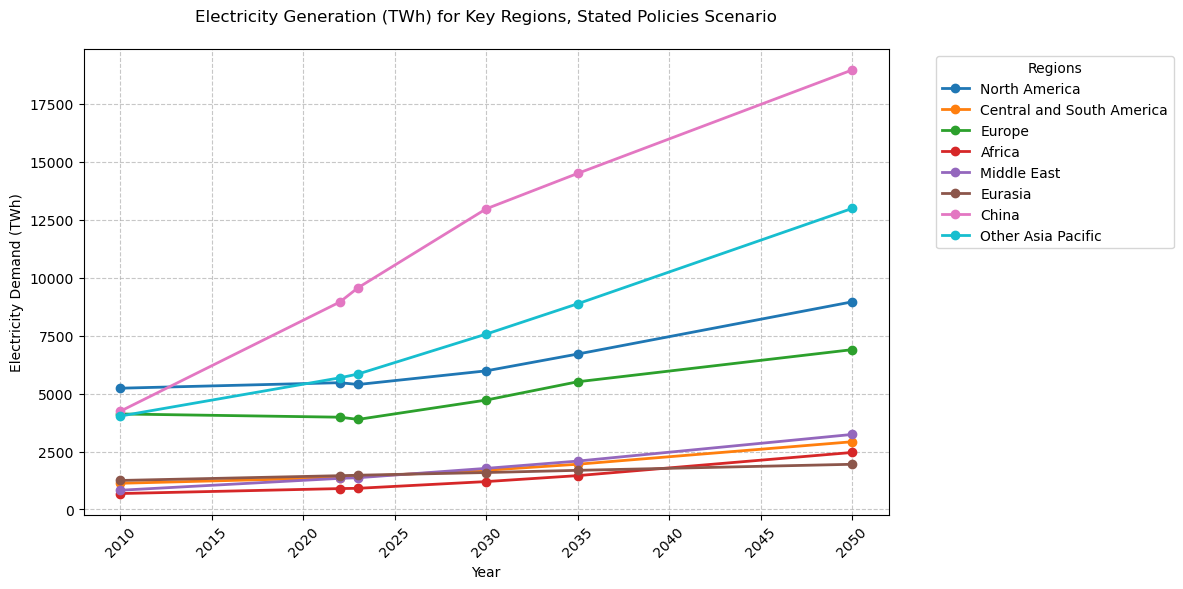

In [1]:
########## import IEA generation data, format into a DataFrame, and plot results ###############

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
file_path = "electricity_generation.csv"
df = pd.read_csv(file_path)

# Define the rows and columns to be removed
rows_to_remove = [0, 1, 3, 5, 7, 9, 13, 16, 17, 18]
columns_to_remove = [4, 8, 9, 10, 11]

# Drop the specified rows
df_cleaned = df.drop(rows_to_remove)

# Drop the specified columns by their index (axis=1 indicates column removal)
df_cleaned = df_cleaned.drop(df_cleaned.columns[columns_to_remove], axis=1)

# Replace NaN values with blank spaces throughout the DataFrame
df_cleaned = df_cleaned.fillna('')

# Remove spaces between numbers in all cells except for the first column (region names)
df_cleaned.iloc[:, 1:] = df_cleaned.iloc[:, 1:].applymap(lambda x: str(x).replace(' ', '') if isinstance(x, str) else x)

# Set the values of the first row (after row drops) as the new column headers
df_cleaned.columns = df_cleaned.iloc[0]

# Drop the first row by using `df_cleaned.index[0]`
df_cleaned = df_cleaned.drop(df_cleaned.index[0])

# Reset the index after dropping the row
df_cleaned = df_cleaned.reset_index(drop=True)

def calculate_other_asia_pacific(df):
    # Get the Asia Pacific and China rows
    asia_pacific = df[df.iloc[:, 0] == 'Asia Pacific'].iloc[0]
    china = df[df.iloc[:, 0] == 'China'].iloc[0]
    
    # Calculate Other Asia Pacific values for each year
    other_asia = []
    other_asia.append('Other Asia Pacific')  # First column is the region name
    
    # For each year column (skipping the first column which is region name)
    for year_col in df.columns[1:]:
        ap_val = pd.to_numeric(asia_pacific[year_col], errors='coerce')
        china_val = pd.to_numeric(china[year_col], errors='coerce')
        other_val = ap_val - china_val
        other_asia.append(str(int(other_val)) if pd.notnull(other_val) else '')
    
    # Create the new row as a DataFrame
    other_asia_row = pd.DataFrame([other_asia], columns=df.columns)
    
    # Remove any existing Other Asia Pacific row
    df = df[df.iloc[:, 0] != 'Other Asia Pacific']
    
    # Add the calculated row
    df = pd.concat([df, other_asia_row], ignore_index=True)
    
    return df

# Apply the calculation to your cleaned DataFrame
df_cleaned = calculate_other_asia_pacific(df_cleaned)

# Print the title
print("Electricity Generation (TWh) for Key Regions, Stated Policies Scenario\n")

# Print the cleaned DataFrame without row numbers
print(df_cleaned.to_string(index=False))

# Create a plotting DataFrame excluding Asia Pacific
df_plot = df_cleaned[df_cleaned.iloc[:, 0] != 'Asia Pacific']

# Convert DataFrame to a NumPy array for plotting
# Exclude the first column (region names) and convert to numeric
data_array = df_plot.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').to_numpy()

# Extract the years from the column headers
years = df_plot.columns[1:].astype(int)

# Define colors for better visualization
colors = {
    'North America': '#1f77b4',
    'Central and South America': '#ff7f0e',
    'Europe': '#2ca02c',
    'Africa': '#d62728',
    'Middle East': '#9467bd',
    'Eurasia': '#8c564b',
    'China': '#e377c2',
    'Other Asia Pacific': '#17becf'
}

# Plotting
plt.figure(figsize=(12, 6))

# Plot each region
for i, region in enumerate(df_plot.iloc[:, 0]):
    plt.plot(years, data_array[i], label=region, linewidth=2, marker='o',
             color=colors.get(region, f'C{i}'))

# Customize the plot
plt.title("Electricity Generation (TWh) for Key Regions, Stated Policies Scenario", 
          fontsize=12, pad=20)
plt.xlabel("Year", fontsize=10)
plt.ylabel("Electricity Demand (TWh)", fontsize=10)
plt.legend(title="Regions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2]:
########## import IEA investment data tables by region ###############

# Define a list of regions
regions = ['Africa', 'North America', 'Europe', 'Middle East', 'Asia Pacific', 'Eurasia', 'China', 'Central and South America']

# Iterate over each region, read the corresponding file, and process it
for region in regions:
    # Construct the file name based on the region
    file_name = f"WorldEnergyInvestment - {region}.csv"
    
    # Read the CSV file
    df = pd.read_csv(file_name)
    
    # Specify the rows to keep (10 to 18 inclusive)
    rows_to_keep = df.iloc[10:19].copy()  # Use .copy() to avoid the SettingWithCopyWarning
    
    # Convert all numeric values in the DataFrame to integers (ignore non-numeric columns)
    rows_to_keep.loc[:, rows_to_keep.columns[1:]] = rows_to_keep.loc[:, rows_to_keep.columns[1:]].astype(float).astype(int)
    
    # Print the result for the current region
    print(f"Investment (Billions, USD) in Power Generation, Storage, and Networks for {region} \n")
    print(rows_to_keep.to_string(index=False))
    print("\n" + "-"*50 + "\n")  # Separator for clarity between regions


Investment (Billions, USD) in Power Generation, Storage, and Networks for Africa 

                 Africa  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024
                  Power    36    35    31    27    24    21    25    31    35    36
             Generation    23    23    20    17    15    15    17    21    25    26
                   Coal     2     2     2     2     1     2     1     1     1     0
    Oil and natural gas    11    11    10     6     5     3     4     3     3     3
                Nuclear     0     0     0     0     0     0     0     0     1     1
             Renewables    11    10     8     8     9    10    12    17    21    22
Fossil fuels: with CCUS     0     0     0     0     0     0     0     0     0     0
                Storage     0     0     0     0     0     0     0     0     0     0
   Electricity networks    12    12    11    10     8     7     8     9     9    10

--------------------------------------------------

Investment (Billions, US


Investment in Power Generation by Region (Billions USD): 

                           2015  2016  2017  2018  2019  2020  2021  2022  2023  2024
Region                                                                               
Africa                       23    23    20    17    15    15    17    21    25    26
North America                96    94    81    81    83    82    85    94   100   111
Europe                      105   104   101   102   105   114   142   166   173   179
Middle East                  15    16    17    16    17    13    14    16    17    19
Eurasia                      14    15    14    13    13    12    14    15    18    20
China                       163   172   184   187   213   227   221   297   379   393
Central and South America    30    25    22    22    22    24    31    42    47    44
Other Asia Pacific          121   117   117   125   131   118   116   122   133   137


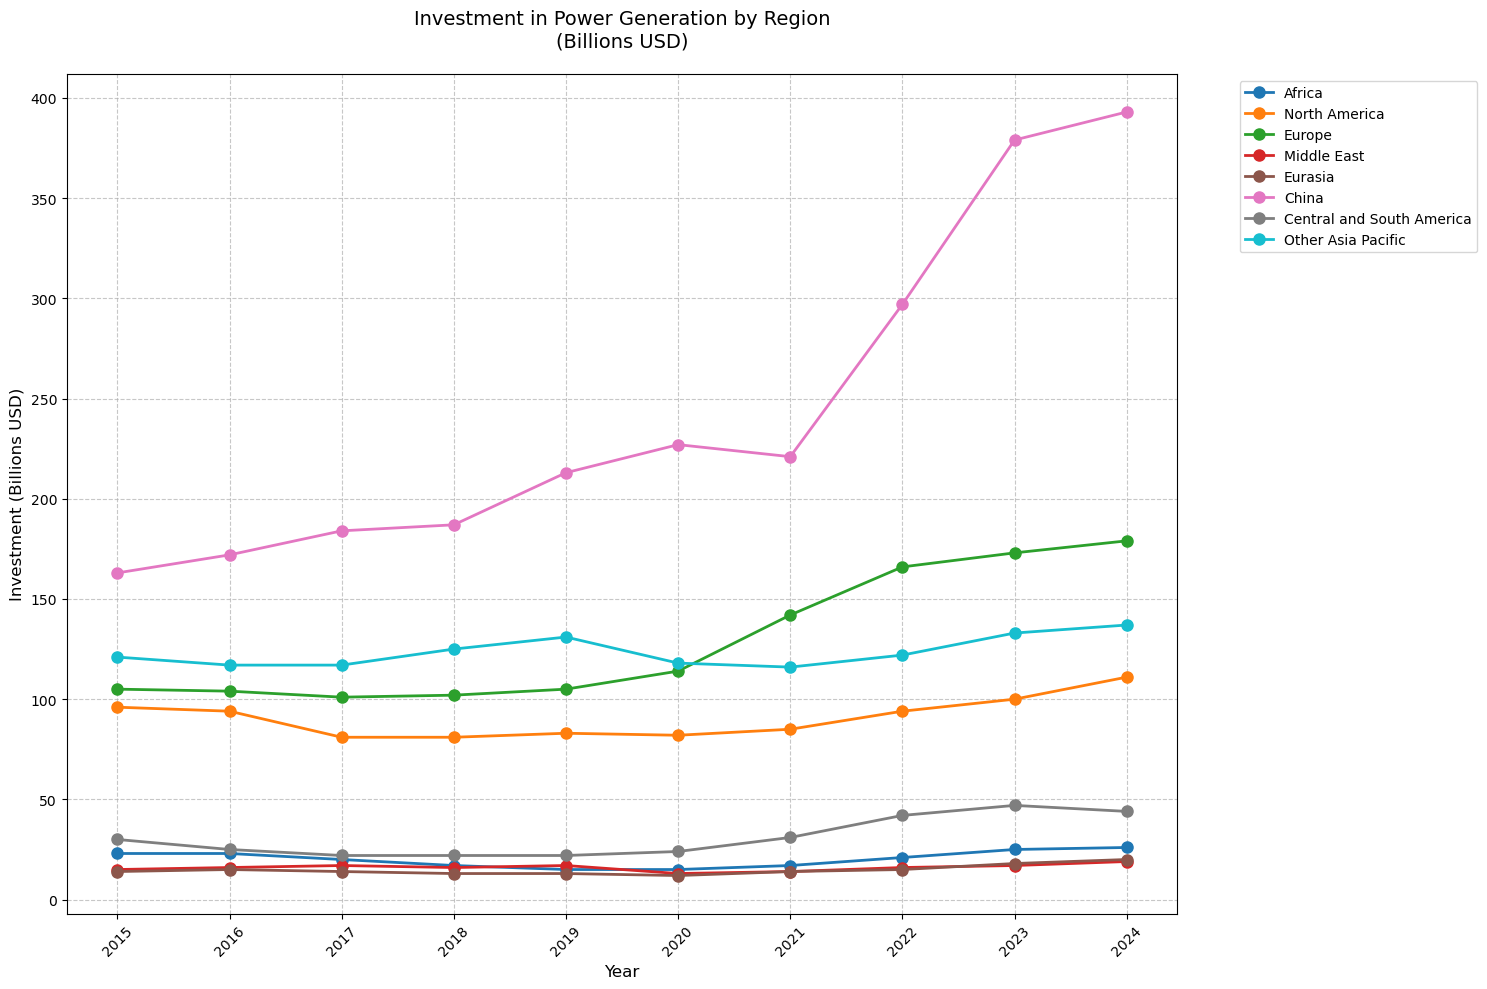

In [3]:
############### merge into one table showing investment only in power generation, and plot results ###############

# Define a list of regions, excluding Asia Pacific
regions = ['Africa', 'North America', 'Europe', 'Middle East', 'Eurasia', 'China', 'Central and South America']

# Dictionary to store DataFrames
region_dfs = {}

# Color scheme for different regions
colors = {
    'Africa': '#1f77b4',  # blue
    'North America': '#ff7f0e',  # orange
    'Europe': '#2ca02c',  # green
    'Middle East': '#d62728',  # red
    'Eurasia': '#8c564b',  # brown
    'China': '#e377c2',  # pink
    'Central and South America': '#7f7f7f',  # gray
    'Other Asia Pacific': '#17becf'  # cyan
}

# Create a figure with larger size
plt.figure(figsize=(15, 10))

# List to store data for the summary table
table_data = []

# Process each region
for region in regions:
    # Construct the file name based on the region
    file_name = f"WorldEnergyInvestment - {region}.csv"
    
    # Read the CSV file
    df = pd.read_csv(file_name)
    
    # Specify the rows to keep (10 to 18 inclusive)
    rows_to_keep = df.iloc[10:19].copy()
    
    # Convert all numeric values in the DataFrame to integers
    rows_to_keep.loc[:, rows_to_keep.columns[1:]] = rows_to_keep.loc[:, rows_to_keep.columns[1:]].astype(float).astype(int)
    
    # Store the processed DataFrame
    region_dfs[region] = rows_to_keep
    
    # Plot the generation investment trend for each region
    years = rows_to_keep.columns[1:].astype(int)  # First column is labels
    generation_investment = rows_to_keep.iloc[1, 1:]  # second row is "generation"
    
    # Store data for table
    table_data.append([region] + list(generation_investment))
    
    plt.plot(years, generation_investment, marker='o', linewidth=2, markersize=8, 
             label=region, color=colors[region])

# Calculate and plot Other Asia Pacific
ap_df = pd.read_csv("WorldEnergyInvestment - Asia Pacific.csv")
ap_rows = ap_df.iloc[10:19].copy()
ap_rows.loc[:, ap_rows.columns[1:]] = ap_rows.loc[:, ap_rows.columns[1:]].astype(float).astype(int)
years = ap_rows.columns[1:].astype(int)
other_ap_generation = ap_rows.iloc[1, 1:] - region_dfs['China'].iloc[1, 1:]

# Add Other Asia Pacific to table data
table_data.append(['Other Asia Pacific'] + list(other_ap_generation))

plt.plot(years, other_ap_generation, marker='o', linewidth=2, markersize=8,
         label='Other Asia Pacific', color=colors['Other Asia Pacific'])

# Customize the plot
plt.title('Investment in Power Generation by Region\n(Billions USD)', 
          fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Investment (Billions USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(years, rotation=45)

# Add padding to prevent label cutoff
plt.tight_layout()

# Create and display the summary table
# Convert table data to DataFrame
columns = ['Region'] + [str(year) for year in years]
summary_table = pd.DataFrame(table_data, columns=columns)

# Set Region as index for better display
summary_table = summary_table.set_index('Region')

# Display both the plot and the table

print("\nInvestment in Power Generation by Region (Billions USD): \n")
print(summary_table.to_string())
plt.show()

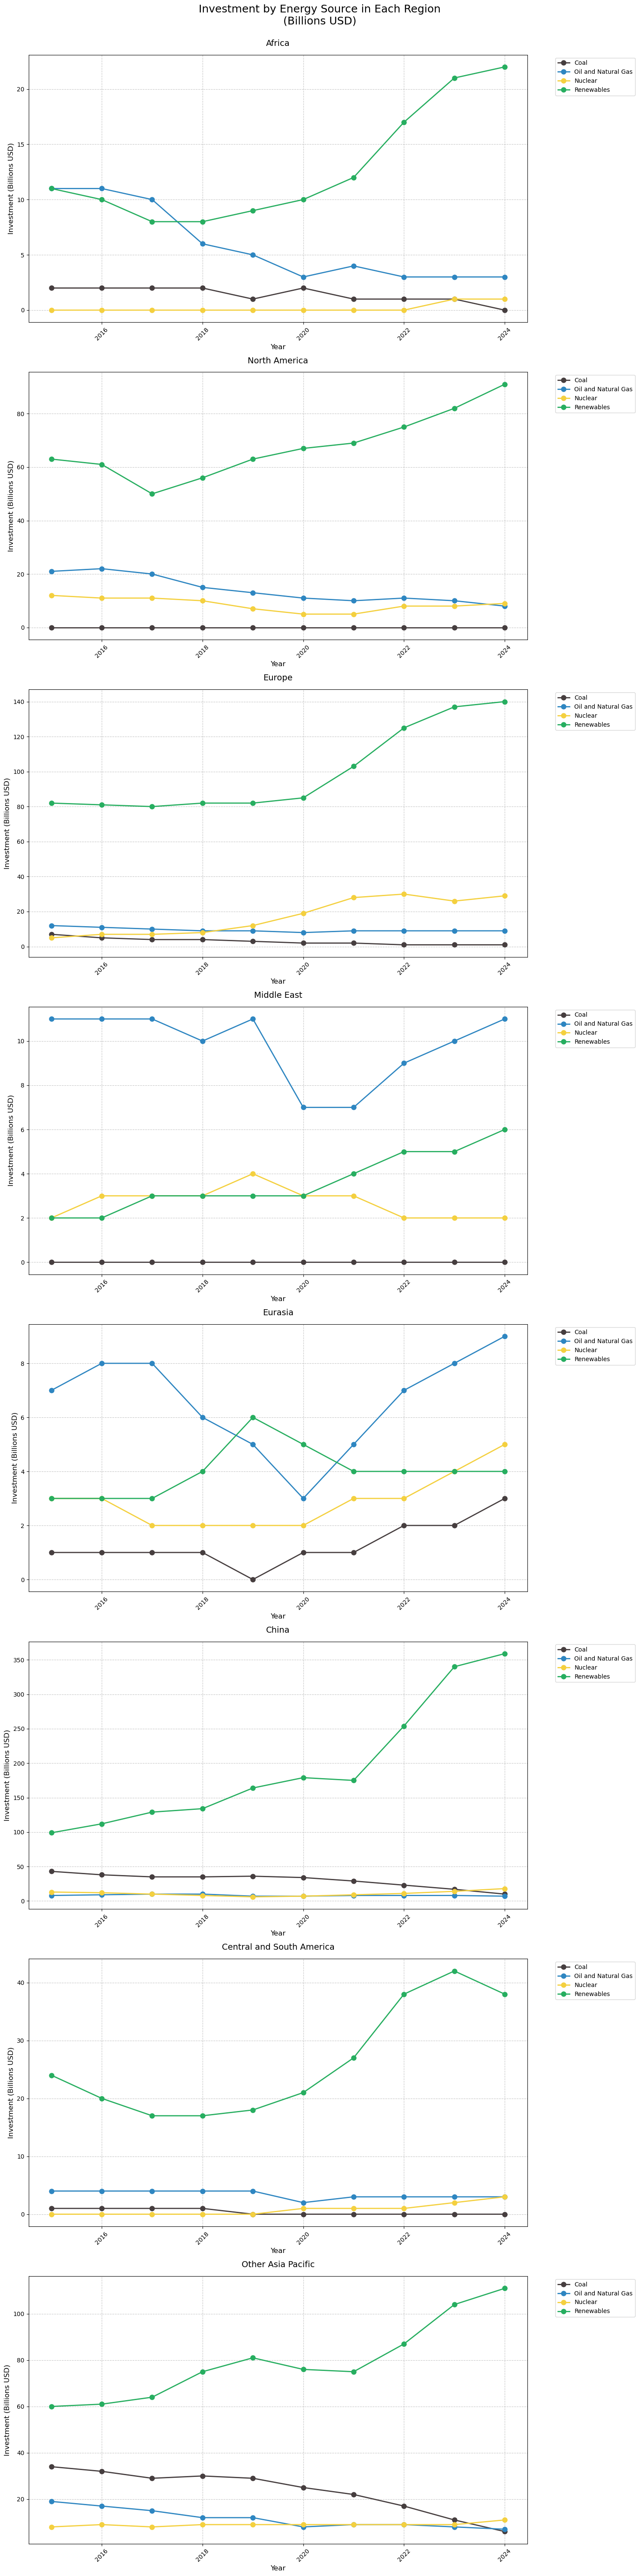

In [4]:
########## Visualize where investment goes, by power generation technology ############

# Create individual plots for each region with investment breakdowns
fig = plt.figure(figsize=(15, 60))  # Increased height for vertical layout
all_regions = regions + ['Other Asia Pacific']

# Updated category indices to show specific power sources
category_indices = {
    'Coal': 2,
    'Oil and Natural Gas': 3,
    'Nuclear': 4,
    'Renewables': 5
}

# Define colors for each category
category_colors = {
    'Coal': '#463E3F',  # dark grey
    'Oil and Natural Gas': '#2E86C1',  # blue
    'Nuclear': '#F4D03F',  # yellow
    'Renewables': '#27AE60'  # green
}

# Create subplots vertically
for idx, region in enumerate(all_regions):
    ax = plt.subplot(8, 1, idx + 1)  # 8 rows, 1 column
    
    if region == 'Other Asia Pacific':
        # For Other Asia Pacific, calculate each category separately
        # Get the years from the AP data
        years = ap_rows.columns[1:].astype(int)
        
        for category, row_idx in category_indices.items():
            category_values = ap_rows.iloc[row_idx, 1:] - region_dfs['China'].iloc[row_idx, 1:]
            investment = category_values
            
            ax.plot(years, investment, marker='o', linewidth=2, markersize=8,
                   label=category, color=category_colors[category])
    else:
        df = region_dfs[region]
        # Get years from the current dataframe
        years = df.columns[1:].astype(int)
        
        # Plot each category
        for category, row_idx in category_indices.items():
            investment = df.iloc[row_idx, 1:]
            ax.plot(years, investment, marker='o', linewidth=2, markersize=8,
                   label=category, color=category_colors[category])
    
    ax.set_title(f'{region}', fontsize=14, pad=15)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Investment (Billions USD)', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.suptitle('Investment by Energy Source in Each Region\n(Billions USD)', fontsize=18, y=1.0)
plt.tight_layout()
plt.show()

There are some clear trends shown in the power generation and investment data:

1. Electricity generation capacity has largely remained stationary in Europe and North America for the last decade, actually decreasing in Europe between 2010 and 2022. This could be due to the fact that generation capacity has largely already met demand, and investments in generation are likely directed towards maintaining existing thermal power plants, nuclear facilities, dams, and other generation infrastructure. The IEA predicts that electricity demand will pick up again in the next few years, driven by the electrification of the residential and transport sectors as well as expansion of the data center sector: https://www.iea.org/reports/electricity-2024/executive-summary

2. There is an strong growth in electricity generation in the Asia-Pacific region, particularly in China, which has seen massive increases in spending since 2021. In other Asian countries, investment feel from 2020- 2022 but is rebounding back upwards, possibly due to the fact that the region was the slowest to recover from the coronavirus pandemic.

3. Renewables are driving the majority of investment in power generation for almost all regions, except those with abundant oil and natural gas resources (Middle East and Eurasia).

## Interpolate data for missing years


To get a rough approximation for the generation- investment ratios for each region, we want to know how much generation capacity (TWh) is added based on investment. This can be expressed either as TWh added/ per billion USD invested, or cost to add 1 TWh of generation capacity. For this analysis we will look at both.

Since there is a lag time between the initial investment in a generation facility and it producing power, we will compare the generation figures (TWh) in year A with investment figures ($) from several years prior. For regions where oil and gas make up the bulk of investment (Middle East and Eurasia), we will approximate a 3 year lag time. For regions where renewables make up the bulk of investment (all other regions), we will approximate a 2 year lag time. These lag times are based on an approximation of the time needed for a project to go from planning to implementation and grid connectivity. (For a more thorough analysis to be conducted in the future, we could conduct a detailed literature review to understand average project completion times by region, and weight the lag times based on the generation mix within each region).

Since our investment data is for the years 2015 - 2024 and we are accounting for 2- to 3- year lag times, we will need generation data from the years 2017 - 2027. Since we only have generation data for the years 2010, 2022, 2023, and 2030 (projected), we will need to interpolate the numbers for the missing years. We will visualize both linear and cubic spline interpolation methods.

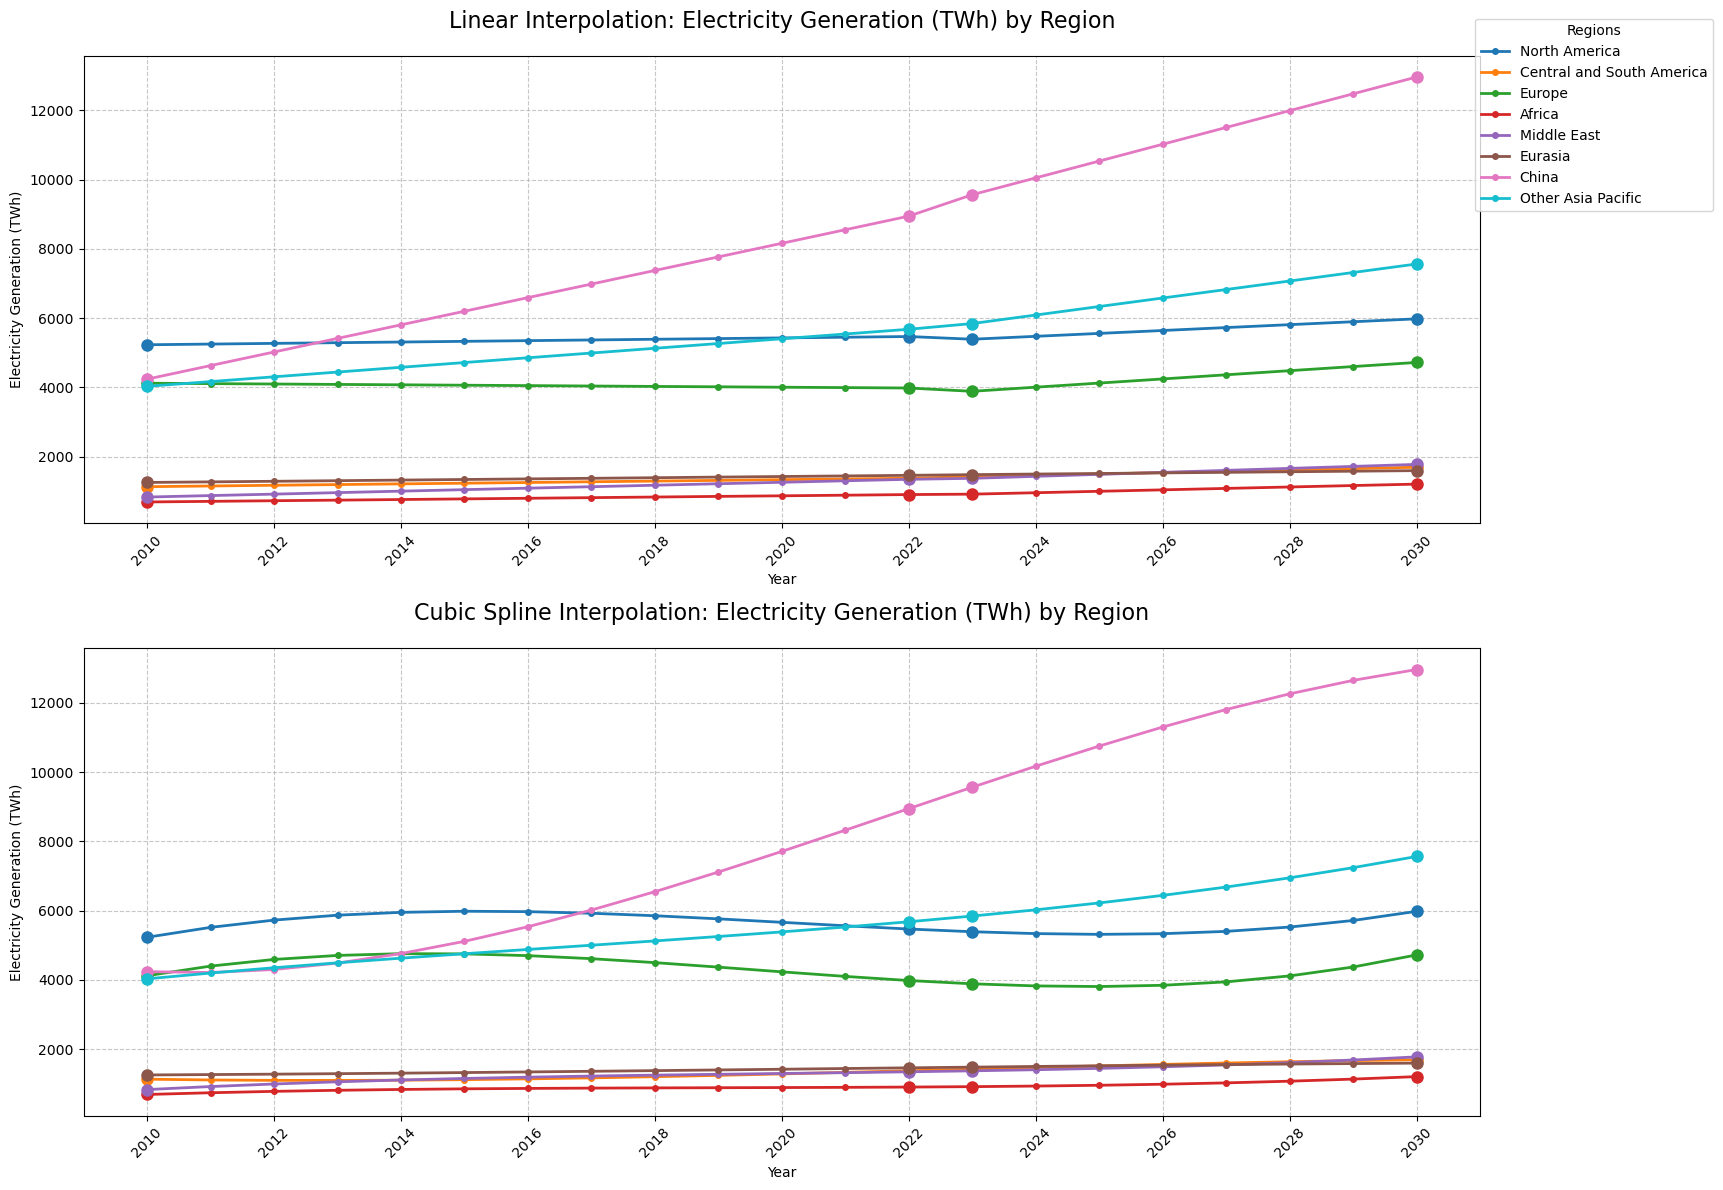

In [5]:
import numpy as np
from scipy.interpolate import interp1d

# Create new DataFrame with focused years from 2010 to 2030
focused_years = list(range(2010, 2031))
new_columns = ['Region'] + [str(year) for year in focused_years]
df_interpolated_linear = pd.DataFrame(columns=new_columns)
df_interpolated_cubic = pd.DataFrame(columns=new_columns)
df_interpolated_linear['Region'] = df_cleaned.iloc[:, 0]
df_interpolated_cubic['Region'] = df_cleaned.iloc[:, 0]

# Perform interpolation for each region
for idx, row in df_cleaned.iterrows():
    region_data_linear = {'Region': row.iloc[0]}
    region_data_cubic = {'Region': row.iloc[0]}
    
    # Convert existing data to numeric, handling any conversion errors
    known_years = np.array([2010, 2022, 2023, 2030])
    known_values = []
    for year in known_years:
        try:
            value = float(row[str(year)].replace(',', ''))
            known_values.append(int(value))
        except (ValueError, AttributeError):
            print(f"Warning: Could not convert value for {year} in region {row.iloc[0]}")
            known_values.append(None)
    
    known_values = np.array(known_values)
    
    # Only proceed with interpolation if we have all known values
    if all(v is not None for v in known_values):
        # Create interpolation functions
        f_linear = interp1d(known_years, known_values, kind='linear')
        f_cubic = interp1d(known_years, known_values, kind='cubic')
        
        # Interpolate for focused years
        for year in focused_years:
            if year in [2010, 2022, 2023, 2030]:  # Use actual values for known years
                try:
                    actual_value = float(row[str(year)].replace(',', ''))
                    region_data_linear[str(year)] = int(actual_value)
                    region_data_cubic[str(year)] = int(actual_value)
                except (ValueError, AttributeError):
                    print(f"Warning: Could not use actual value for {year} in region {row.iloc[0]}")
                    linear_val = float(f_linear(year))
                    cubic_val = float(f_cubic(year))
                    region_data_linear[str(year)] = int(np.round(linear_val))
                    region_data_cubic[str(year)] = int(np.round(cubic_val))
            else:  # Interpolate other years
                linear_val = float(f_linear(year))
                cubic_val = float(f_cubic(year))
                region_data_linear[str(year)] = int(np.round(linear_val))
                region_data_cubic[str(year)] = int(np.round(cubic_val))
    else:
        print(f"Warning: Cannot interpolate for region {row.iloc[0]} due to missing values")
        for year in focused_years:
            region_data_linear[str(year)] = None
            region_data_cubic[str(year)] = None
    
    df_interpolated_linear.loc[idx] = pd.Series(region_data_linear)
    df_interpolated_cubic.loc[idx] = pd.Series(region_data_cubic)

# Create plotting DataFrames excluding Asia Pacific
df_plot_linear = df_interpolated_linear[df_interpolated_linear['Region'] != 'Asia Pacific'].set_index('Region')
df_plot_cubic = df_interpolated_cubic[df_interpolated_cubic['Region'] != 'Asia Pacific'].set_index('Region')

# Convert string columns to numeric, dropping the 'Region' column for plotting
plot_cols = [str(year) for year in focused_years]
df_plot_linear = df_plot_linear[plot_cols].apply(pd.to_numeric, errors='coerce')
df_plot_cubic = df_plot_cubic[plot_cols].apply(pd.to_numeric, errors='coerce')

# Define colors for regions
colors = {
    'North America': '#1f77b4',
    'Central and South America': '#ff7f0e',
    'Europe': '#2ca02c',
    'Africa': '#d62728',
    'Middle East': '#9467bd',
    'Eurasia': '#8c564b',
    'China': '#e377c2',
    'Other Asia Pacific': '#17becf'
}

# Create subplots for comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot Linear Interpolation
for region in df_plot_linear.index:
    data = df_plot_linear.loc[region].values.astype(float)
    ax1.plot(focused_years, data, label=region, linewidth=2,
             marker='o', markersize=4,
             color=colors.get(region, f'C{list(df_plot_linear.index).index(region)}'))
    
    # Add markers for actual data points
    actual_years = [2010, 2022, 2023, 2030]
    actual_indices = [focused_years.index(year) for year in actual_years if year in focused_years]
    actual_data = [data[idx] for idx in actual_indices]
    ax1.plot(actual_years, actual_data, 'o',
             color=colors.get(region, f'C{list(df_plot_linear.index).index(region)}'),
             markersize=8)

# Plot Cubic Spline Interpolation
for region in df_plot_cubic.index:
    data = df_plot_cubic.loc[region].values.astype(float)
    ax2.plot(focused_years, data, label=region, linewidth=2,
             marker='o', markersize=4,
             color=colors.get(region, f'C{list(df_plot_cubic.index).index(region)}'))
    
    # Add markers for actual data points
    actual_years = [2010, 2022, 2023, 2030]
    actual_indices = [focused_years.index(year) for year in actual_years if year in focused_years]
    actual_data = [data[idx] for idx in actual_indices]
    ax2.plot(actual_years, actual_data, 'o',
             color=colors.get(region, f'C{list(df_plot_cubic.index).index(region)}'),
             markersize=8)

# Customize the plots
ax1.set_title("Linear Interpolation: Electricity Generation (TWh) by Region", fontsize=16, pad=20)
ax2.set_title("Cubic Spline Interpolation: Electricity Generation (TWh) by Region", fontsize=16, pad=20)

for ax in [ax1, ax2]:
    ax.set_xlabel("Year", fontsize=10)
    ax.set_ylabel("Electricity Generation (TWh)", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks(focused_years[::2])  # Show every other year to avoid overcrowding
    ax.tick_params(axis='x', rotation=45)

# Add legend to the right of the plots
lines1, labels1 = ax1.get_legend_handles_labels()
fig.legend(lines1, labels1, title="Regions", 
          bbox_to_anchor=(1.15, 0.9), loc='center right')

plt.tight_layout()
plt.show()

## Perform ratio operations

In [6]:
def calculate_regional_time_series_dual(df_gen_linear, df_gen_cubic, df_inv, region, start_year=2017, end_year=2027):
    """
    Calculate generation-investment ratios for a region using both linear and cubic interpolation data,
    comparing generation increases with lagged investment data.
    
    Parameters:
    df_gen_linear: DataFrame with linear interpolated generation data
    df_gen_cubic: DataFrame with cubic interpolated generation data
    df_inv: DataFrame with investment data
    region: String name of region to analyze
    start_year: First year to analyze (default: 2017)
    end_year: Last year to analyze (default: 2027)
    
    Returns:
    Tuple of DataFrames (linear_results, cubic_results)
    """
    lag_time = 3 if region in ['Middle East', 'Eurasia'] else 2
    
    def calculate_metrics(df_gen):
        results = []
        for year in range(start_year, end_year + 1):
            try:
                # Get current and previous generation values
                current_gen = float(df_gen.loc[region, str(year)])
                prev_gen = float(df_gen.loc[region, str(year-1)])
                
                # Calculate generation increase
                gen_increase = current_gen - prev_gen
                
                # Get investment value from lagged year
                investment_year = str(year - lag_time)
                if investment_year in df_inv.columns:
                    investment = float(df_inv.loc[region, investment_year])
                    
                    # Calculate ratios
                    if investment != 0:
                        twh_per_billion = gen_increase / investment
                        cost_per_twh = investment / gen_increase if gen_increase != 0 else np.nan
                    else:
                        twh_per_billion = np.nan
                        cost_per_twh = np.nan
                    
                    results.append({
                        'Year': year,
                        'Investment_Year': year - lag_time,
                        'Generation_Increase_TWh': round(gen_increase, 2),
                        'Investment_Billion_USD': round(investment, 2),
                        'TWh_per_Billion_USD': round(twh_per_billion, 2) if not np.isnan(twh_per_billion) else np.nan,
                        'Cost_per_TWh_Million_USD': round(cost_per_twh * 1000, 2) if not np.isnan(cost_per_twh) else np.nan
                    })
                else:
                    results.append({
                        'Year': year,
                        'Investment_Year': year - lag_time,
                        'Generation_Increase_TWh': round(gen_increase, 2),
                        'Investment_Billion_USD': np.nan,
                        'TWh_per_Billion_USD': np.nan,
                        'Cost_per_TWh_Million_USD': np.nan
                    })
            except (KeyError, ValueError, TypeError) as e:
                print(f"Error processing {region} for year {year}: {str(e)}")
                results.append({
                    'Year': year,
                    'Investment_Year': year - lag_time,
                    'Generation_Increase_TWh': np.nan,
                    'Investment_Billion_USD': np.nan,
                    'TWh_per_Billion_USD': np.nan,
                    'Cost_per_TWh_Million_USD': np.nan
                })
                continue
        
        return pd.DataFrame(results)
    
    # Calculate results for both interpolation methods
    linear_results = calculate_metrics(df_gen_linear)
    cubic_results = calculate_metrics(df_gen_cubic)
    
    return linear_results, cubic_results

# Generate tables for each region using both interpolation methods
regions = df_plot_linear.index.tolist()  # Assuming df_plot_linear and df_plot_cubic have the same regions
regional_analyses_dual = {}

for region in regions:
    linear_df, cubic_df = calculate_regional_time_series_dual(
        df_plot_linear, df_plot_cubic, summary_table, region
    )
    regional_analyses_dual[region] = {
        'linear': linear_df,
        'cubic': cubic_df
    }

# Print results for each region
for region, analyses in regional_analyses_dual.items():
    print(f"\n{region} Generation-Investment Analysis:")
    print("=" * 100)
    
    print("\nLinear Interpolation Results:")
    print("-" * 80)
    print(analyses['linear'].to_string(index=False))
    
    print("\nCubic Spline Interpolation Results:")
    print("-" * 80)
    print(analyses['cubic'].to_string(index=False))
    print("\n")


North America Generation-Investment Analysis:

Linear Interpolation Results:
--------------------------------------------------------------------------------
 Year  Investment_Year  Generation_Increase_TWh  Investment_Billion_USD  TWh_per_Billion_USD  Cost_per_TWh_Million_USD
 2017             2015                     20.0                    96.0                 0.21                   4800.00
 2018             2016                     20.0                    94.0                 0.21                   4700.00
 2019             2017                     19.0                    81.0                 0.23                   4263.16
 2020             2018                     20.0                    81.0                 0.25                   4050.00
 2021             2019                     20.0                    83.0                 0.24                   4150.00
 2022             2020                     20.0                    82.0                 0.24                   4100.00
 2023   

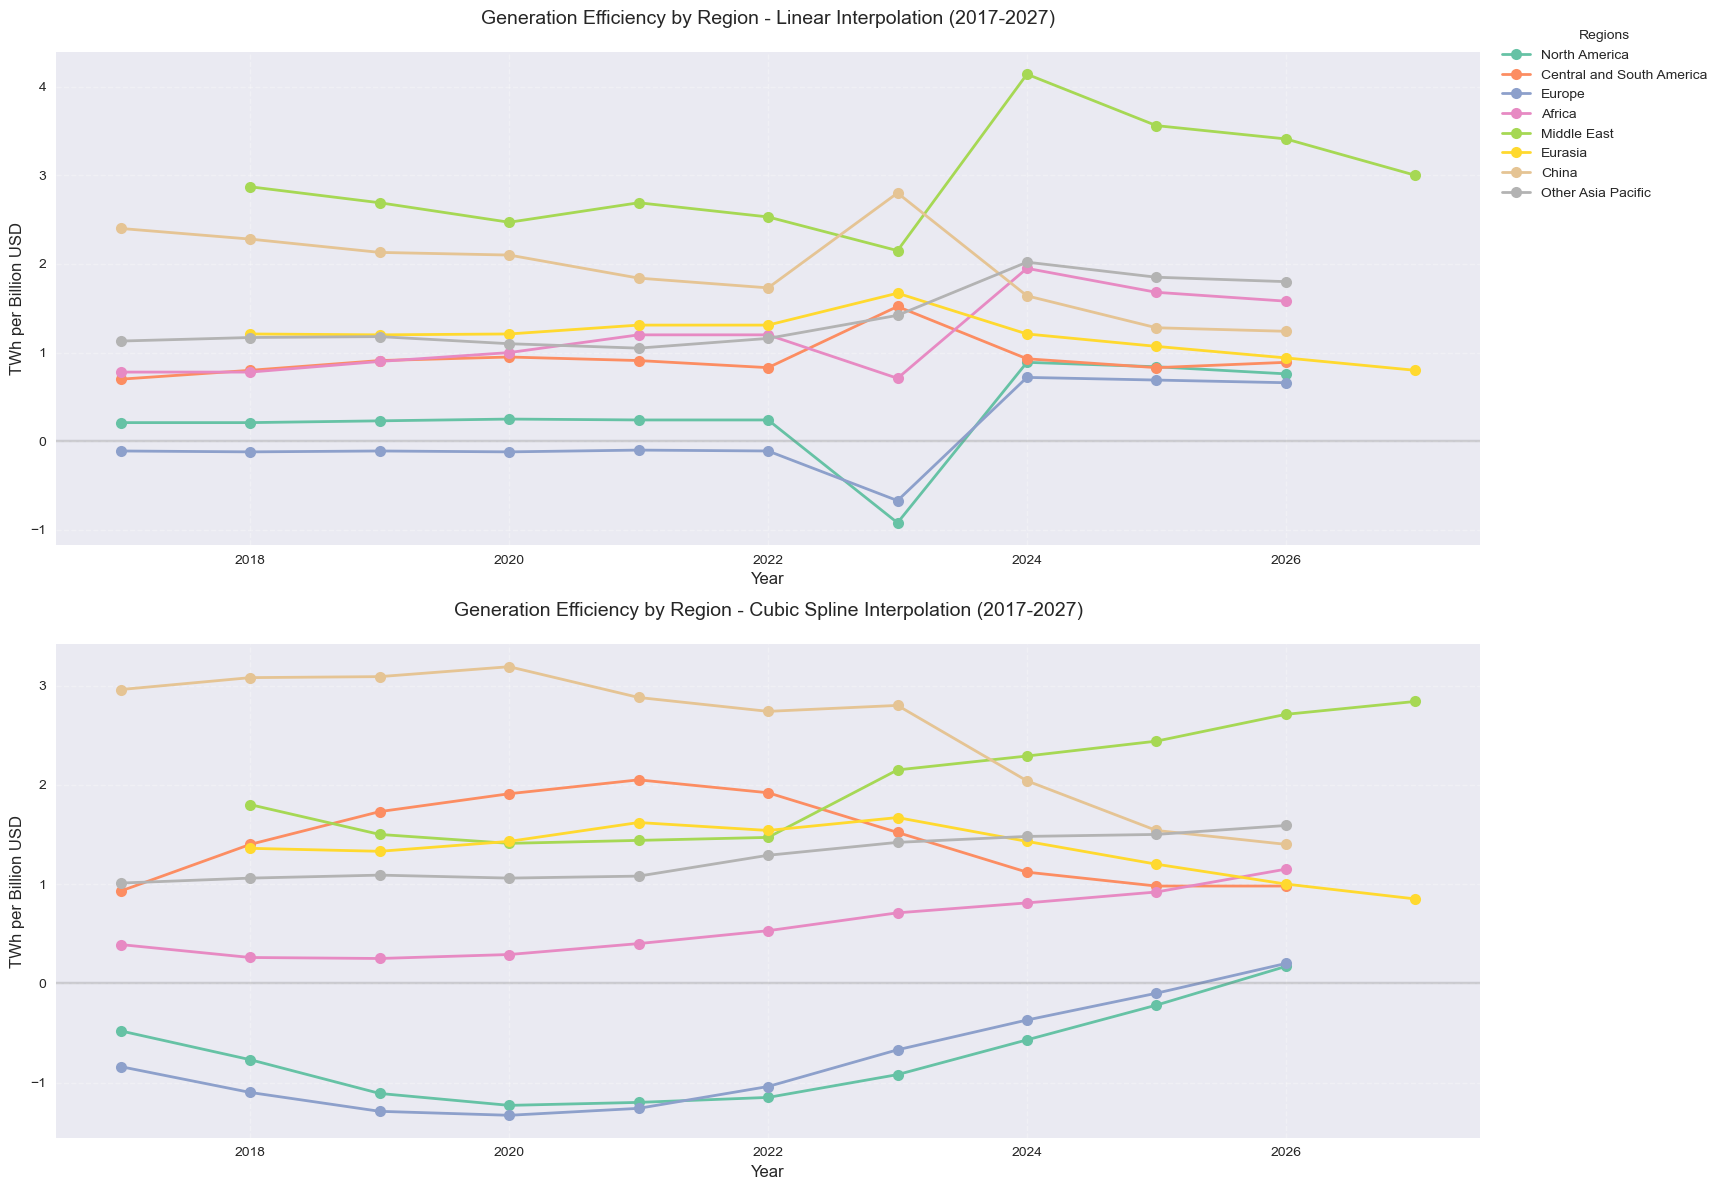

In [7]:
def plot_dual_twh_per_billion(regional_analyses_dual, save_path=None):
    """
    Create a visualization comparing TWh per Billion USD across regions for both
    linear and cubic spline interpolations.
    
    Parameters:
    regional_analyses_dual: Dictionary of dictionaries containing regional analyses
                          for both linear and cubic interpolation
    save_path: Optional path to save the figure (e.g., 'twh_per_billion.png')
    """
    # Set style and create figure with two subplots
    plt.style.use('seaborn')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Create color palette
    colors = plt.cm.Set2(np.linspace(0, 1, len(regional_analyses_dual)))
    
    # Plot data for each region - Linear Interpolation
    for (region, analyses), color in zip(regional_analyses_dual.items(), colors):
        df_linear = analyses['linear']
        ax1.plot(df_linear['Year'], df_linear['TWh_per_Billion_USD'], 
                marker='o', 
                linewidth=2, 
                markersize=8,
                label=region,
                color=color)
    
    # Plot data for each region - Cubic Spline Interpolation
    for (region, analyses), color in zip(regional_analyses_dual.items(), colors):
        df_cubic = analyses['cubic']
        ax2.plot(df_cubic['Year'], df_cubic['TWh_per_Billion_USD'], 
                marker='o', 
                linewidth=2, 
                markersize=8,
                label=region,
                color=color)
    
    # Customize the plots
    ax1.set_title('Generation Efficiency by Region - Linear Interpolation (2017-2027)', 
                fontsize=14, pad=20)
    ax2.set_title('Generation Efficiency by Region - Cubic Spline Interpolation (2017-2027)', 
                fontsize=14, pad=20)
    
    for ax in [ax1, ax2]:
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('TWh per Billion USD', fontsize=12)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    # Add legend to the right of the plots
    lines1, labels1 = ax1.get_legend_handles_labels()
    fig.legend(lines1, labels1, title="Regions", 
              bbox_to_anchor=(1.15, 0.9), loc='center right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Example usage:
# Plot all regions with both interpolation methods
fig = plot_dual_twh_per_billion(regional_analyses_dual)
plt.show()

## Interpret Results

There's a lot to unpack in our final graphs showing generation efficiency by region, measured in terms of added generation power (TWh) for every billion dollars invested. While neither interpolation method can be fully accurate, the cubic spline method has the advantage of not assuming major shifts in efficiency for 2023, the one year we had fully accurate data for calculating this ratio. In that year, the most "efficient" regions were China and the Middle East, followed by Eurasia, Central/ South America, Other Asia Pacific. Slightly below that is Africa, and far below that is Europe and North America. These ratios were calculated with investments made in 2021, (or in the case of Middle East/ Eurasia, in 2020).

But this ratio seems to reflect less on how effectively different regions spend their money, and more about whether their priorities are adding more generation capacity or maintaining existing generation infrastructure. After all, Europe and North America cannot be so inefficient that they are spending hundreds of billions of dollars only to have their generation capacity decrease over a decade.

Because interpolated data does not represent actual outcomes, it's important to know where we can and cannot draw conclusions. In all likelihood, year-to-year trends are less informative than the long-term trends and comparisons between regions.

1. We see Europe and North America's effiency ratios trending upward, likely reflecting a renewed focus on adding generation capacity due to reasons discussed above (electrification of buildings and transport sectors, expansion of data centers).

2. Africa, the Middle East, and Other Asia Pacific are trending upwards as well, as those regions experience population growth and develop economically - necessitating increases in generation capacity.

3. China was the most "efficient" for the last decade. Not only was their primary focus on adding more capacity (especially with renewables), but also their economies of scale and a strong manufacturing sector could have actually made their efforts more cost effective.

4. The Middle East is anticipated to be the next most "efficient" region, set to increase their generation capacity by 30% by 2030. This might be because of the high resource availability of oil and natural gas and the lower cost of extracting and processing it.

5. China, Eurasia, and Central/ South America are trending downward in "efficiency". This is because investment has picked up in recent years (especially in China since 2021), but the added generation resulting from this investment is spread out between 2023 and the projected 2030 estimate based on our intepolation method. The focus for these regions is likely still adding more capacity. Additionally, the 2030 generation estimate is based on the more conservative Stated Policies Scenario, and it's probable that some regions will overshoot this target.

## Conclusion

My initial goal with this project was to see which regions were more cost effective with their investments in adding electricity generation capacity. However, this cannot be determined due to lack of data showing investment specifically geared towards adding generation capacity. However, we can see from comparison between regions that the Middle East and China are the regions which add the most capacity based on the amount of investment; this could reflect both a higher priority on adding capacity, as well as being actually more effective with how they are spending money for reasons discussed above.

It's important to keep in mind the data limitations and assumptions made in this project:

1. The power generation for 2030 is just an estimate
2. Generation data is only factual for the years 2010, 2022, and 2023, and data for the other years is interpolated using these years and the 2030 estimate
3. Lag times between investment and generation are broadly assumed to be 2 or 3 years, depending on the primary power source for the region